In [1]:
import numpy as np
import pandas as pd

# Loading dataset
mnist_data = np.load('mnist.npz')
X_train = mnist_data['x_train']
Y_train = mnist_data['y_train']
X_test = mnist_data['x_test']
Y_test = mnist_data['y_test']

# Same as Q1
is_class_01 = (Y_train == 0) | (Y_train == 1)
X_train = X_train[is_class_01]
Y_train = Y_train[is_class_01]

is_class_02 = (Y_test == 0) | (Y_test == 1)
X_test = X_test[is_class_02]
Y_test = Y_test[is_class_02]

# normalize them
X_train = X_train.reshape(-1, 28 * 28) / 255.0
X_test = X_test.reshape(-1, 28 * 28) / 255.0
print(X_train.shape)

# Relabelling
Y_train = np.where(Y_train==0,-1,1)
Y_test = np.where(Y_test == 0,-1,1)

# Splitting into the training set into training and validation sets
num_samples_class_0 = 1000
num_samples_class_1 = 1000

X_train_class_0 = X_train[Y_train == -1]
Y_train_class_0 = Y_train[Y_train == -1]

X_train_class_1 = X_train[Y_train == 1]
Y_train_class_1 = Y_train[Y_train == 1]

print(X_train_class_0)
X_train_val = np.vstack((X_train_class_0[:num_samples_class_0], X_train_class_1[:num_samples_class_1]))
Y_train_val = np.hstack((Y_train_class_0[:num_samples_class_0], Y_train_class_1[:num_samples_class_1]))


X_train = np.vstack((X_train_class_0[num_samples_class_0:], X_train_class_1[num_samples_class_1:]))
Y_train = np.hstack((Y_train_class_0[num_samples_class_0:], Y_train_class_1[num_samples_class_1:]))

print(X_train_class_0[num_samples_class_0:].shape)
print(X_train_val.shape)
print(X_train.shape)
print(Y_train_val.shape)

mean_vector = np.mean(X_train, axis=0)
mean_vector1 = np.mean(X_test, axis=0)

cov_matrix = np.cov((X_train - mean_vector).T)
cov_matrix1 = np.cov((X_test - mean_vector1).T)

eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
eigenvalues1, eigenvectors1 = np.linalg.eigh(cov_matrix1)

sorted_indices = np.argsort(eigenvalues)[::-1]
top_p_indices = sorted_indices[:5]
sorted_indices1 = np.argsort(eigenvalues1)[::-1]
top_p_indices1 = sorted_indices1[:5]

pca_matrix = eigenvectors[:, top_p_indices]
pca_matrix1 = eigenvectors1[:, top_p_indices1]

print(pca_matrix.shape)
X_train_pca = np.dot(X_train - mean_vector, pca_matrix)
X_val_pca = np.dot(X_train_val - mean_vector, pca_matrix)

print("Shape of reduced training data:", X_train_pca.shape)
print("Shape of reduced validation data:", X_val_pca.shape)


(12665, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(4923, 784)
(2000, 784)
(10665, 784)
(2000,)
(784, 5)
Shape of reduced training data: (10665, 5)
Shape of reduced validation data: (2000, 5)


In [2]:
#  Finding unique values and sorting them for the dimension

unique_sorted_values_train = [np.sort(np.unique(X_train_pca[:, i])) for i in range(X_train_pca.shape[1])]
unique_sorted_values_val = [np.sort(np.unique(X_val_pca[:, i])) for i in range(X_val_pca.shape[1])]

for i, values in enumerate(unique_sorted_values_train):
    print(f"Dimension {i+1} in training data:", values)

for i, values in enumerate(unique_sorted_values_val):
    print(f"Dimension {i+1} in validation data:", values)


Dimension 1 in training data: [-9.14050887 -9.12628801 -8.98098105 ...  4.42735384  4.46459577
  4.4702065 ]
Dimension 2 in training data: [-6.06722951 -5.9901054  -5.54732112 ...  3.79543166  3.85617239
  3.90544954]
Dimension 3 in training data: [-5.56645578 -5.49364676 -5.47483353 ...  4.95061807  5.00174571
  5.00814084]
Dimension 4 in training data: [-5.31601761 -5.31149254 -5.22410596 ...  4.88780727  4.9698394
  5.09538818]
Dimension 5 in training data: [-3.6491333  -3.59755316 -3.57806115 ...  4.64196635  4.65935191
  5.42137539]
Dimension 1 in validation data: [-8.96990919 -8.59099587 -8.47369653 ...  4.32894399  4.3445438
  4.3650654 ]
Dimension 2 in validation data: [-5.18271121 -4.98273991 -4.97617406 ...  3.61741336  3.78122422
  3.84658567]
Dimension 3 in validation data: [-5.72106446 -5.32494584 -5.29495264 ...  4.82954624  4.8421774
  4.93588225]
Dimension 4 in validation data: [-5.33371114 -5.32356401 -5.19678641 ...  4.21573374  4.25409641
  4.28758238]
Dimension 5 in

In [3]:
#  Calculate Sum of Squared Residuals (SSR)
def calculate_ssr(y, y_left, y_right):
    ssr_right = np.sum((y_right - np.mean(y_right))**2)
    ssr_left = np.sum((y_left - np.mean(y_left))**2)

    return ssr_left + ssr_right

def find_best_split(X, y):

    best_split_feature = None
    best_ssr = float('inf')
    best_split_value = None
    
    for feature in range(X.shape[1]):
        unique_values = np.sort(np.unique(X[:, feature]))
        midpoints = (unique_values[:-1] + unique_values[1:]) / 2
        
        for value in midpoints:
            left_indices = X[:, feature] <= value
            right_indices = X[:, feature] > value
            
            y_left = y[left_indices]
            y_right = y[right_indices]
            
            ssr = calculate_ssr(y, y_left, y_right)
            
            if ssr < best_ssr:
                best_ssr = ssr

                best_split_value = value
                best_split_feature = feature
                
    return best_split_feature, best_split_value

# Decision stump
best_split_feature, best_split_value = find_best_split(X_train_pca, Y_train)

print(f"Best split: {best_split_feature}, Best split value: {best_split_value}")


Best split: 0, Best split value: 0.7445328110204548


In [4]:
# Calculate predictions h1(x) for the best split
def predict_split(X, feature, value):
    return X[:, feature] <= value

predictions_train = predict_split(X_train_pca, best_split_feature, best_split_value)
predictions_val = predict_split(X_val_pca, best_split_feature, best_split_value)

residue_train = Y_train - 0.01 * predictions_train
residue_val = Y_train_val - 0.01 * predictions_val

print("Residue for training set:", residue_train[:10])
print("Residue for validation set:", residue_val[:10])


Residue for training set: [-1.01 -1.01 -1.01 -1.01 -1.01 -1.01 -1.01 -1.01 -1.01 -1.01]
Residue for validation set: [-1.01 -1.01 -1.01 -1.01 -1.01 -1.01 -1.01 -1.01 -1.01 -1.01]


In [5]:
def update_residue(y, predictions, learning_rate=0.01):
    return y - learning_rate * predictions

stumps = []
residues_val = []
residues_train = []

# Taking the initial residue 
current_residue_train = Y_train.copy()
current_residue_val = Y_train_val.copy()

for i in range(20):
    best_split_feature, best_split_value = find_best_split(X_train_pca, current_residue_train)
    
    predictions_train = predict_split(X_train_pca, best_split_feature, best_split_value)
    
    predictions_val = predict_split(X_val_pca, best_split_feature, best_split_value)
    
    stumps.append((best_split_feature, best_split_value))
    
    current_residue_train = update_residue(current_residue_train, predictions_train)
    current_residue_val = update_residue(current_residue_val, predictions_val)
    
    residues_train.append(current_residue_train.copy())
    residues_val.append(current_residue_val.copy())

    # Printing each iteration
    if (i+1) % 50 == 0:
        print(f"Iteration {i+1}/300 completed")

residues_val = np.array(residues_val)
residues_train = np.array(residues_train)

print("Residues for validation set after 300 stumps:", residues_val[-1][:20])

print("Residues for training set after 300 stumps:", residues_train[-1][:20])

import matplotlib.pyplot as plt

# MSE Calculation
def compute_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Compute MSE on validation set after each iteration
mse_val = [compute_mse(Y_train_val, residue) for residue in residues_val]
mse_val = mse_val[::-1]


Residues for validation set after 300 stumps: [-1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2
 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2]
Residues for training set after 300 stumps: [-1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2
 -1.2 -1.2 -1.2 -1.2 -1.2 -1.2]


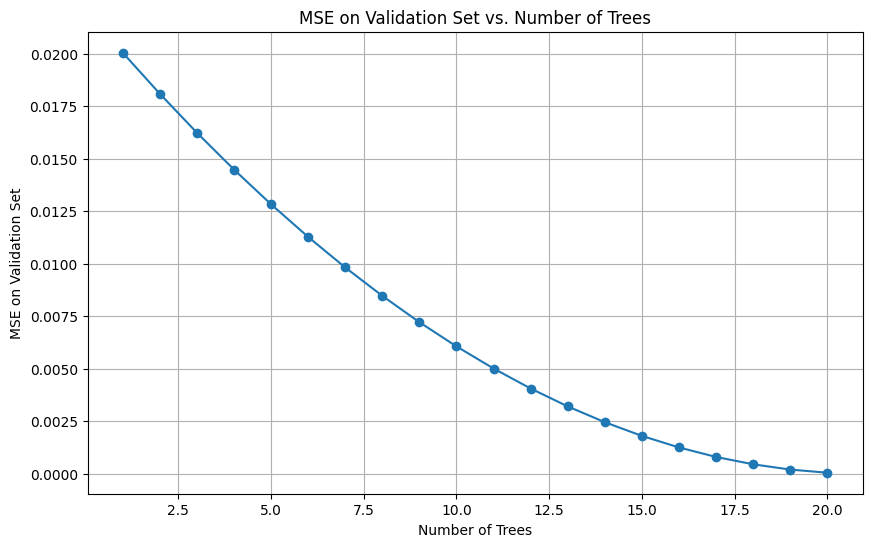

Test MSE for the best stump: 0.9986342789598108


In [6]:



# Plot MSE on validation set vs. number of trees
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), mse_val, marker='o', linestyle='-')
plt.title('MSE on Validation Set vs. Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('MSE on Validation Set')
plt.grid(True)
plt.show()

# Identify the tree with the lowest MSE
best_tree_idx = np.argmin(mse_val)
best_stump = stumps[best_tree_idx]

# Evaluate the best tree on the test set
def evaluate_stump(X, stump):
    feature, value = stump
    predictions = predict_split(X, feature, value)
    # 0.01 learning rate
    return 0.01 * predictions  

predictions_test = evaluate_stump(X_test, best_stump)

# Test MSE
mse_test = compute_mse(Y_test, predictions_test)

print(f"Test MSE for the best stump: {mse_test}")
